In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

Tue Mar 22 15:54:13 PDT 2022


In [5]:
# numpyro imports

from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Simulate Ipos data and fit it with numpyro

$\text{Ipos}(p) \propto \frac{\left(p(1-p)\right)^\alpha}{p}$ where $\text{Ipos}(p)$ is the probability that a PLWHIV is in a stable, serodiscordant couple, and $p$ is the HIV seroprevalence (both measured in DHS or a similar survey).

I will simulate data according to this relationship with a known $\alpha$ and 25 DHS surveys of around 1,000 people each, and then estimate $\alpha$ from a nonlinear model using `numpyro`.  Mexin can adapt this to her real dataset.

In [2]:
n_samples = 20
alpha_true = 0.80
ipos_concentration_true = 25

epsilon = 1/1_000  # technically this is part of the model, not the simulated data

np.random.seed(12345) # set random seed for reproducibility

# simulate data for testing model
df = pd.DataFrame()

df['n_total'] = np.round(np.random.normal(1_000, 200, n_samples)).astype(int)

df['p_hiv_true'] = np.random.beta(1, 9, n_samples)
df['n_hiv'] = np.random.binomial(df.n_total, df.p_hiv_true)
df['p_hiv_obs'] = df.n_hiv / df.n_total

p = df['p_hiv_true']
df['ipos_true'] = (p * (1-p))**alpha_true / p
Z = (epsilon * (1 - epsilon))**alpha_true / (epsilon)
df['ipos_true'] /= Z # normalize so that Ipos(epsilon) = 1 --- choice of epsilon is a bit arbitrary

df['n_ipos'] = np.random.binomial(df.n_hiv, np.random.beta(ipos_concentration_true*df.ipos_true,
                                                           ipos_concentration_true*(1-df.ipos_true)))
df['ipos_obs'] = df.n_ipos / df.n_hiv

df

,n_total,p_hiv_true,n_hiv,p_hiv_obs,ipos_true,n_ipos,ipos_obs
0,959,0.295969,284,0.296142,0.242199,78,0.274648
1,1096,0.002536,3,0.002737,0.829169,3,1.000000
2,896,0.213080,185,0.206473,0.282738,54,0.291892
3,889,0.109075,126,0.141732,0.357006,18,0.142857
...,...,...,...,...,...,...,...
16,600,0.094901,52,0.086667,0.371750,31,0.596154
17,926,0.094501,107,0.115551,0.372195,30,0.280374
18,1334,0.384333,523,0.392054,0.206482,94,0.179732
19,912,0.046761,36,0.039474,0.446408,12,0.333333


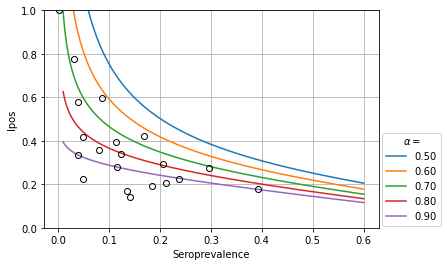

In [3]:
plt.plot(df.p_hiv_obs.values, df.ipos_obs, 'o', mec='k', mew=1, color='none', zorder=10)
plt.xlabel('Seroprevalence')
plt.ylabel('Ipos')
plt.axis(ymin=0, ymax=1)
plt.grid()
def my_plot_curves():
    p = np.linspace(.01,.6,num=500)

    for alpha in np.linspace(.5,.9,num=5):
        X = (p * (1 - p))**alpha/p
        X /= (epsilon * (1 - epsilon))**alpha_true / epsilon

        
        plt.plot(p, X, label=f'{alpha:.2f}')
    plt.legend(title='$\\alpha=$', loc=(1.01, .01))
my_plot_curves()

In [4]:
# columns that Mexin will have from DHS
df.filter(['n_total', 'n_hiv', 'n_ipos'])  # I think

,n_total,n_hiv,n_ipos
0,959,284,78
1,1096,3,3
2,896,185,54
3,889,126,18
...,...,...,...
16,600,52,31
17,926,107,30
18,1334,523,94
19,912,36,12


In [6]:
# simplest model
def model(n_total, n_hiv, n_ipos):
    n_samples = len(n_total)
    
    p_hiv = numpyro.sample('p_hiv', dist.Beta(jnp.ones(n_samples), jnp.ones(n_samples)))
    n_hiv_obs = numpyro.sample('n_hiv_obs', dist.Binomial(n_total, p_hiv), obs=n_hiv)

    alpha = numpyro.sample('alpha', dist.TruncatedNormal(loc=1, scale=1, low=0, high=2))
    Z = (epsilon * (1 - epsilon))**alpha / epsilon
    p_ipos = ( (p_hiv * (1-p_hiv))**alpha / p_hiv) / Z
    
    n_ipos_obs = numpyro.sample('n_ipos_obs', dist.Binomial(n_hiv, p_ipos), obs=n_ipos)



kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0), df.n_total.values, df.n_hiv.values, df.n_ipos.values)
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:05<00:00, 360.20it/s, 7 steps of size 6.40e-01. acc. prob=0.85]


In [7]:
print('alpha_true', alpha_true)
print('alpha est (with uncertainty):', f'{samples["alpha"].mean():.3f}', 
         np.round(np.percentile(samples['alpha'], [2.5, 97.5]), 3))

alpha_true 0.8
alpha est (with uncertainty): 0.777 [0.764 0.789]


In [8]:
# probably better to model n_ipos as a beta binomial
def model(n_total, n_hiv, n_ipos):
    n_samples = len(n_total)
    
    p_hiv = numpyro.sample('p_hiv', dist.Beta(jnp.ones(n_samples), jnp.ones(n_samples)))
    n_hiv_obs = numpyro.sample('n_hiv_obs', dist.Binomial(n_total, p_hiv), obs=n_hiv)

    alpha = numpyro.sample('alpha', dist.TruncatedNormal(loc=1, scale=1, low=.1, high=1.1))
    lambda_ipos = numpyro.sample('lambda_ipos', dist.Uniform(low=10, high=10_000))
    Z = (epsilon * (1 - epsilon))**alpha / epsilon
    p_ipos = ((p_hiv * (1-p_hiv))**alpha / p_hiv) / Z
    
    n_ipos_obs = numpyro.sample('n_ipos_obs', dist.BetaBinomial(lambda_ipos*p_ipos,
                                                               lambda_ipos*(1-p_ipos), n_hiv), obs=n_ipos)



kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0), df.n_total.values, df.n_hiv.values, df.n_ipos.values)
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:08<00:00, 232.29it/s, 7 steps of size 5.12e-01. acc. prob=0.89]


In [9]:
print('alpha_true', alpha_true)
print('alpha est (with uncertainty):', f'{samples["alpha"].mean():.3f}', 
         np.round(np.percentile(samples['alpha'], [2.5, 97.5]), 3))

alpha_true 0.8
alpha est (with uncertainty): 0.786 [0.752 0.819]


# Some MCMC diagnostics

(To make sure we did a good job fitting the model)

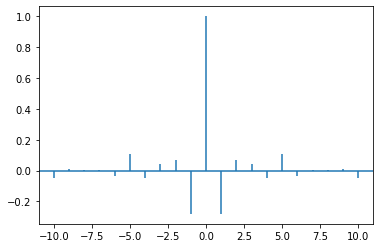

In [10]:
plt.acorr(samples['alpha']-samples['alpha'].mean());

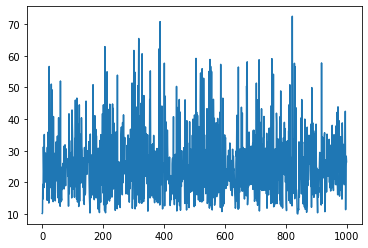

In [11]:
plt.plot(samples['lambda_ipos'])

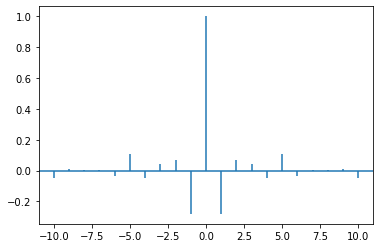

In [12]:
plt.acorr(samples['alpha']-samples['alpha'].mean());

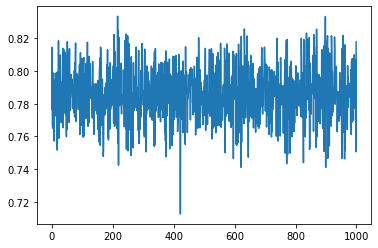

In [13]:
plt.plot(samples['alpha'])

In [14]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
        alpha      0.79      0.02      0.79      0.76      0.81   1290.44      1.00
  lambda_ipos     25.29     10.95     22.88     10.29     40.93   1154.87      1.00
     p_hiv[0]      0.30      0.01      0.30      0.27      0.32   1665.13      1.00
     p_hiv[1]      0.00      0.00      0.00      0.00      0.01   1620.32      1.00
     p_hiv[2]      0.21      0.01      0.21      0.19      0.23   1925.29      1.00
     p_hiv[3]      0.14      0.01      0.14      0.13      0.16   1244.98      1.00
     p_hiv[4]      0.18      0.01      0.18      0.17      0.20   1700.21      1.00
     p_hiv[5]      0.14      0.01      0.14      0.12      0.15   1907.42      1.00
     p_hiv[6]      0.03      0.01      0.03      0.02      0.04   1778.37      1.00
     p_hiv[7]      0.21      0.01      0.21      0.19      0.23   1678.88      1.00
     p_hiv[8]      0.08      0.01      0.08      0.07      0.09   1471.32  